# Introduction
In this jupyter notebook, we are presenting our program with the help of text explanation 
and basic examples of function usage. The goal of this document is to propose an 
interactive, step-by-step understanding of how each fraction of the code works.

## Basics
Our program uses a states machine to handle the main events. Image processing is done using
OpenCV. The GUI has been created with the Tkinter library. We use an external file 
(src/thymio.py) which has been written for the course of Mobile Robotics in order to create
a bridge from Python to the Thymio. Finally, we use some JSON and SQL library in order to
communicate with the ScratchJr program.

## The program modules
The program is separated into several different modules (represented by different py file) 
which are the following:
#### main.py
This is our main function which handles the state machine, update the session and the GUI.
#### tk_gui.py
Creates and handles the main window and the popup windows. This file is described in another jupyter notebook.
#### session.py
Contains the class States used for our state machine, the class Module to know whether
we are using Thymio or ScratchJr and the class Session which contains all the information 
about the library of tiles, the program, and the module (Thymio VS ScratchJr) used. It also
provides the function add_element_to_librairy, interpret_image, save_file and execute which
mainly impact the Session objects.
#### save_load
Used for initialization and closing of a session. It loads the library in accordance to the
module (Thymio or ScratchJr) at initialization and saves if necessary (if tiles have been
added) at the session closing.
#### find_frames.py and fuse.py
These functions respectively take care of finding the tile on the image and fusing the 
duplicates.
#### rectify.py
Modifies the previously found tile to make them horizontal and vertical.
#### compare_tiles.py
Compares the rectified tiles with our library of tiles and return the tile that has the best
likeliness.
#### grids.py
Creates a grid with the position of the previously found tile (find_frames.py and fuse.py)
and link them with their respective tile (compare_tiles.py) to make a grid which represents
the program on the image.
#### average.py
Make an average over the last X results. This reduced the noise a lot and, doing so, improve
our results
#### program.py
Create a numpy array which lines and columns represent the program on the image 
and also create the corresponding image with the tile pictures from the library.
#### bridge_scratch_jr.py
Link to ScratchJr. Send the program on the image into the ScratchJr Database.
#### bridge_thymio.py
Link to th Thymio. Simulates the program on the thymio by getting all the thymio sensors 
values (event tile) and updating the actuators (action tile) according to the program on the 
image.

# The code
We will now go through the code, step-by-step
## Imports

In [9]:
# Basics import 
import os
import sys
import time

# OpenCV for image processing
import cv2
import numpy as np

# To check whether a Thymio is connected
import serial.tools.list_ports

# For communication with ScratchJr
import json
import sqlite3

# Else
from math import sqrt
from enum import Enum, auto
from PIL import Image

# Imports only needed for the jupyter notebook
from matplotlib import pyplot as plt

## Session class
The first thing the program does is  initializing a session :

    # Can be useful if we want to work simultaneously with several sessions
    # Need to be implemented
    my_sessions = [session.Session()]
    working_session = 0

We will present you first the session class which contain the information about the image and 
the image processing part. But before we need to initialize some classes.

In [10]:
# The States class which is used in our state machine
class States(Enum):
    GAME_CHOICE = auto()  # Before the user chooses between Thymio or Scratch
    IMG_SOURCE_CHOICE = auto()  # Webcam, capture or image file
    WEBCAM_CHOICE = auto()  # Webcam number (0 is the computer integrated webcam or the 1st detected by the system
    CAPTURE_CHOICE = auto()  # Webcam number but for Capture mode
    WEBCAM_MAIN = auto()  # Image capture and processing
    IMG_FILE_MAIN = auto()
    CAPTURE_MAIN = auto()
    LAUNCH_WEBCAM = auto()  # Launch the interpreted program on the system module
    LAUNCH_FILE = auto()
    LAUNCH_CAPTURE = auto()
    EXECUTE_WEBCAM = auto()  # Executes it after it has been launched
    EXECUTE_FILE = auto()
    EXECUTE_CAPTURE = auto()
    EXIT = auto()
    
# The Module class to know whether we are working with a Thymio or with Scratch
class Module(Enum):
    THYMIO = auto()
    SCRATCH = auto()
    
# And finally the Session class
class Session:
    def __init__(self):
        self.state = States.GAME_CHOICE  # Statche machine
        self.tile_librairy = []
        self.tile_librairy_resized = []  # Because we use smaller tile to compare them with the image
        self.tile_type = []  # Event, action or other
        self.module = None  # Thymio or Scratch
        self.module_logo = None
        self.average_grid = []  # saves the last N grids detected by the program
        self.average_tile = []
        self.best_grid = []  # the best grid averaged over average_grid
        self.best_tile = []
        self.best_program = []  # Best program as an image (displayed on the GUI)
        self.program_tile = []  # Best program as tiles
        self.current_event_tile = []  # Last event tile detected by the thymio (not used with scratch)
        self.scenery = None  # Scratch parameter
        self.character = None  # Scratch parameter
        
    def reset(self):
        self.state = States.GAME_CHOICE
        self.tile_librairy = []
        self.tile_librairy_resized = []
        self.tile_type = []
        self.module = None
        self.module_logo = None
        self.average_grid = []
        self.average_tile = []
        self.best_grid = []
        self.best_tile = []
        self.best_program = []
        self.program_tile = []
        self.current_event_tile = []
        self.scenery = None
        self.character = None
        

## Save_load
Then we enter into the state machine. As we want to focus on Image Processing first, we will
skip a few steps and directly explain the library loading :

    my_sessions[working_session].module = Module.THYMIO
    tile_librairy, tile_librairy_resized, tile_type = save_load.load_data(Module.THYMIO)
    
This will look for ".png" file in the correct path according to the module and load the 
librairy, save the original tile, the resize version and the tile type in session.
    

In [11]:
ORIGINAL_TILE_SIZE = 200
RESIZED_TILE_SIZE = 50

# Describe the category of each tile. Will be used in compare_tile to compare different specifications
# like background color, top band color etc...
ACTION_TILE = ["Action_Color_Blue", "Action_Color_Green", "Action_Color_Red", "Action_Color_Yellow",
               "Motors_Backward", "Motors_Forward", "Motors_Forward_Left", "Motors_Forward_Right",
               "Motors_Left", "Motors_Right", "Motors_Stop"]
EVENT_TILE = ["Button_Bottom", "Button_Center", "Button_Left", "Button_Right", "Button_Top",
              "Event_Color_Blue", "Event_Color_Green", "Event_Color_Red", "Event_Color_Yellow",
              "Ground_Black", "Ground_White", "Ground_Black_White", "Ground_White_Black", "Ground_Edge",
              "Obstacle_Front", "Obstacle_Left", "Obstacle_Right", "Obstacle_Back_Right", "Obstacle_Back_Light",
              "Event_Timer", "Action_Timer_3", "Clap"]
SCRATCH_TILE = ["Start_On_Click", "Start_Green_Flag", "Forward", "Backward", "Up", "Down", "Say", "Forever", "End"]

EVENT = "event"
ACTION = "action"
ACT = "act"
SCRATCH = "scratch"
CUSTOM_TILE = "custom"

def load_data(module):
    """Load the librairy save in the /data/templ_imgs folder and also sort the tile in the librairy by type"""
    tile_library = dict()
    tile_librairy_resized = dict()
    tile_type = {EVENT: [], ACTION: [], ACT: [], SCRATCH: [], CUSTOM_TILE: []}
    if module == Module.THYMIO:
        path = "data/templ_imgs_thymio"
    else:
        path = "data/templ_imgs_scratch"
    # Look for png file in data/templ_imgs and save them and with their name in tile_librairy
    for file in os.listdir(os.getcwd() + "/" + path):
        if file.endswith(".png"):
            temp_image = cv2.imread(path + "/" + file)
            if temp_image is None:
                sys.exit("can not load librairy")
                break
            temp_image = cv2.resize(temp_image, (ORIGINAL_TILE_SIZE, ORIGINAL_TILE_SIZE))
            tile_library.update({os.path.splitext(file)[0]: temp_image})
            temp_image = cv2.resize(temp_image, (RESIZED_TILE_SIZE, RESIZED_TILE_SIZE))
            tile_librairy_resized.update({os.path.splitext(file)[0]: temp_image})

    for key in tile_library:
        if key in EVENT_TILE:
            tile_type[EVENT].append(key)
        elif key in ACTION_TILE:
            tile_type[ACTION].append(key)
        elif key in SCRATCH_TILE:
            tile_type[SCRATCH].append(key)
        else:
            tile_type[CUSTOM_TILE].append(key)

    return tile_library, tile_librairy_resized, tile_type


def save_data(tile_librairy, module):
    """save all images in tile_librairy with their key as name"""
    if module == Module.THYMIO:
        path = "/data/templ_imgs_thymio"
    else:
        path = "/data/templ_imgs_scrtach"
    for key in tile_librairy:
        cv2.imwrite(os.getcwd() + path + key + ".png", tile_librairy[key])

We can now initialize a session and load data from the librairy.

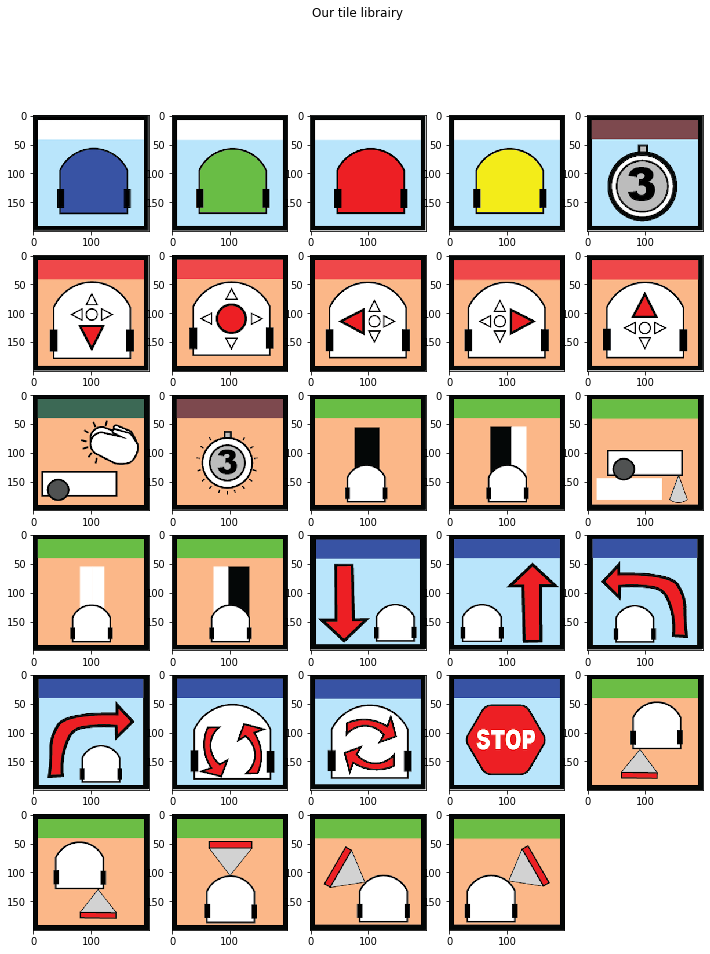

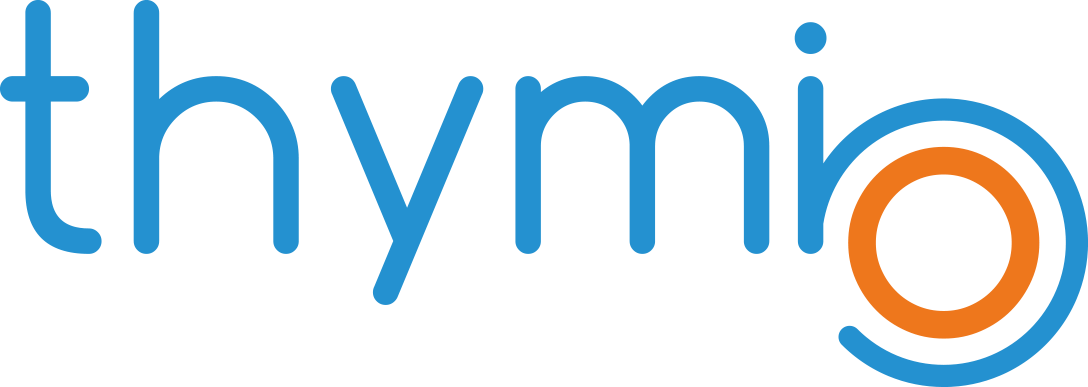

In [12]:
session = Session()
session.module = Module.THYMIO
session.module_logo = Image.open(os.getcwd() + "/data/logo/thymio_logo.png")
tile_library, tile_library_resized, tile_type = load_data(Module.THYMIO)

session.tile_library = tile_library
session.tile_library_resized = tile_library_resized
session.tile_type = tile_type
session.state = States.IMG_SOURCE_CHOICE  # We have automatically chosen the Thymio module here

fig = plt.figure(figsize = (12, 15))
fig.suptitle("Our tile librairy")
ax = []

for i, key in enumerate(tile_library):
    ax.append(fig.add_subplot(6, 5, i+1))
    RGB_image = cv2.cvtColor(tile_library[key], cv2.COLOR_BGR2RGB)
    ax[i].imshow(RGB_image)

plt.show()
display(session.module_logo)

This doesn't really makes sense in a jupyter notebook but this is how we implemented static
variables in our project (used in several different files and functions)

In [13]:
def static_vars(**kwargs):
    """"Decorator used to define static variable in function"""

    def decorate(func):
        for k in kwargs:
            setattr(func, k, kwargs[k])
        return func

    return decorate

The next function is actually not used but is already written in the case someone would like
to implement the possibility of adding new tiles in the library with the help of existing tile.

One example of static variable is also shown here. The static variable is 
add_element_to_library.counter and it is initialized at 0.

In [14]:
@static_vars(counter=0)
def add_element_to_library(session, element_to_add, name_of_the_element=""):
    """"Add a new element in the librairy. If no name is given, it uses the name
        "new_element_x" with x being the xth element without name added"""
    if name_of_the_element == "":
        add_element_to_library.counter += 1
        name_of_the_element = "new_element_" + str(add_element_to_library.counter)
    element_to_add = cv2.resize(element_to_add, (ORIGINAL_TILE_SIZE, ORIGINAL_TILE_SIZE))
    session.tile_librairy.update({name_of_the_element: element_to_add})
    element_to_add = cv2.resize(element_to_add, (RESIZED_TILE_SIZE, RESIZED_TILE_SIZE))
    session.tile_librairy_resized.update({name_of_the_element: element_to_add})
    
    

# Image processing
Next function is the one doing the image processing and extracting all the information out
of the image. The function description describes every step. What we will do additionnaly
in this notebook is showing every intermediate result.

In [15]:
def interpret_image(image, session):
    """Input : original image and current session
    Make all operations to find the program on the image. In the order :
    1. Look for the tiles contour
    2. Rectify the image such that the frames are horizontal and vertical
    3. Compare the tiles with the tile librairy
    4. Make a grid out of all previous results
    5. Show the program"""
    
    contours_frames = find_contour_frames(image)
    rectified_object = rectify_image(contours_frames, image, RESIZED_TILE_SIZE)
    if len(rectified_object.contours):
        rectified_object = compare_tiles(rectified_object, session.tile_librairy_resized,
                                            session.tile_type, RESIZED_TILE_SIZE)
        rectified_object.grid_list, rectified_object.grid_order = \
            sort_to_grids(rectified_object, session.tile_librairy_resized)

    update_program(rectified_object, session)
    session.program_tile, session.best_program = show_best_program(session, ORIGINAL_TILE_SIZE)

## Find contours
So let's start with find_contour_frames which takes the webcam image as input and give the
contours position as output (numpy array).

The main steps are:
    1. Applying a canny filter
    2. Using findContours algorithm (all the points, cyan, green and red)
    3. Sort the contour, top to bottom then left to right
    4. Approximate contours corner with approxPolyDP (only red and green points)
    5. Checking if the contour is a frame (tile) contour 
    6. Fusing the points +/- aligned (only red points which represent our frame contours)

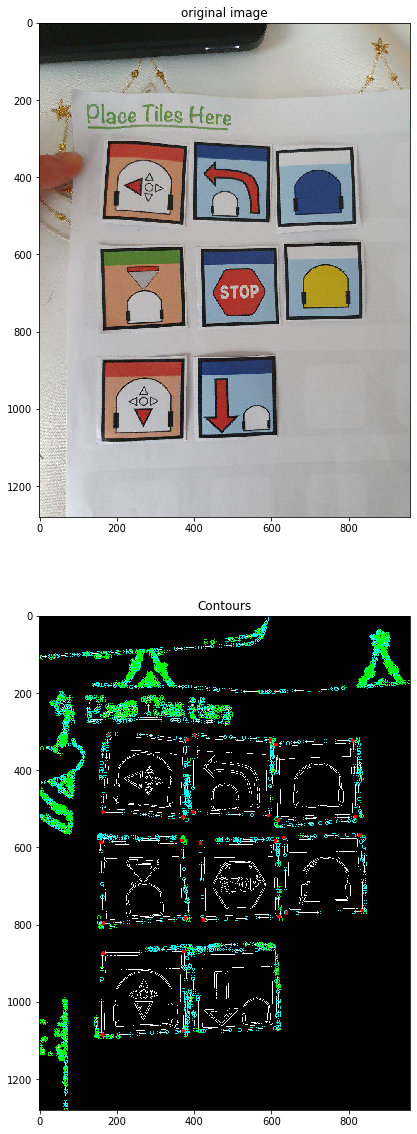

[[array([180, 308]), array([165, 509]), array([372, 522]), array([382, 322])],
 [array([402, 310]), array([398, 509]), array([594, 518]), array([598, 323])],
 [array([811, 324]), array([613, 334]), array([619, 530]), array([819, 520])],
 [array([830, 569]), array([634, 575]), array([640, 770]), array([836, 764])],
 [array([370, 582]), array([160, 587]), array([166, 796]), array([378, 783])],
 [array([612, 584]), array([418, 589]), array([425, 788]), array([620, 779])],
 [array([375, 870]),
  array([165, 874]),
  array([ 164, 1084]),
  array([ 372, 1075])]]

In [16]:
# Constants definition for find_frames.py
SIZE_THRESHOLD = 5000
# Constants definition for fuse.py
POS_X = 0
POS_Y = 1
THRESHOLD_COLLINEAR = 0.2
PROXIMITY_PIX = 10
INFINITY_SLOPE = 10
NUMBER_OF_CORNER = 4

def find_contour_frames(image, debug):  # We added debug in this jupyter notebook to plot intermediate results 
    """Find quadrilateral shapes in the image that are bigger than the threshold defined abow"""
    edges = cv2.Canny(cv2.medianBlur(image, 5), 30, 90)

    # Works better without it
    # kernel = np.ones((3, 3))
    # edges = cv2.dilate(edges, kernel)
    # cv2.imshow("original", image)
    # cv2.imshow("canny", edges)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
    # sort the contours from top to bottom then left to right
    contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0] + cv2.boundingRect(ctr)[1] * image.shape[1])

    edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    for contour in contours:
        for point in contour:
            cv2.circle(edges, (point[0][0], point[0][1]), 5, (255, 255, 0))

    contours_frame = []
    for contour in contours:
        contour = cv2.approxPolyDP(contour, cv2.arcLength(contour, True) * 0.01, True)
        for point in contour:
            cv2.circle(edges, (point[0][0], point[0][1]), 5, (0, 255, 0))
        if is_contour_frame(contour):
            contours_frame.append(contour)

    contours_frame = fuse_points_in_contours(contours_frame)

    for contour in contours_frame:
        for point in contour:
            cv2.circle(edges, (point[0], point[1]), 5, (0, 0, 255), -1)
            
    # cv2.imshow("final", edges)
    
    if debug:
        fig = plt.figure(figsize = (20, 20))

        ax1 = fig.add_subplot(2, 1, 1)
        RGB_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax1.imshow(RGB_image)
        ax1.set_title('original image')

        ax2 = fig.add_subplot(2, 1, 2)
        RGB_image = cv2.cvtColor(edges, cv2.COLOR_BGR2RGB)
        ax2.imshow(RGB_image)
        ax2.set_title('Contours')

        plt.show()

    return contours_frame

def is_contour_frame(contour):
    """Check whether the contour has 4 point (is a quadrilateral) and is bigger than the threshold"""
    if (contour.size >= 8 and
            abs(cv2.contourArea(contour)) > SIZE_THRESHOLD and
            cv2.isContourConvex(contour)):
        return True
    else:
        return False

    
# The next functions are written in fuse.py
def fuse_points_in_contours(contours):
    """Erase useless points (collinear or too close)"""
    new_contours = []
    for contour in contours:
        contour_fuse_point = fuse_duplicates_points(contour)

        index_contour = []
        new_contour = []

        if len(contour_fuse_point) > NUMBER_OF_CORNER:
            for index in range(len(contour_fuse_point)):
                if index == (len(contour_fuse_point) - 2):
                    index_temp1 = 0
                    index_temp2 = index + 1
                elif index == (len(contour_fuse_point) - 1):
                    index_temp1 = 1
                    index_temp2 = 0
                else:
                    index_temp1 = index + 2
                    index_temp2 = index + 1
                pt1 = contour_fuse_point[index]
                pt2 = contour_fuse_point[index_temp2]
                pt3 = contour_fuse_point[index_temp1]
                if collinear(pt1, pt2, pt3):
                    index_contour.append(index + 1)

            for index, point in enumerate(contour_fuse_point):
                if any(index == x for x in index_contour):
                    pass
                else:
                    new_contour.append(contour_fuse_point[index])
            if len(new_contour) == NUMBER_OF_CORNER:
                new_contours.append([new_contour[0][0], new_contour[1][0], new_contour[2][0], new_contour[3][0]])
        elif len(contour_fuse_point) == NUMBER_OF_CORNER:
            new_contours.append([contour_fuse_point[0][0], contour_fuse_point[1][0], contour_fuse_point[2][0],
                                 contour_fuse_point[3][0]])

    return new_contours


def collinear(pt1, pt2, pt3):
    """Control if three points are collinear"""
    slope1 = get_slope_contour(pt1[0], pt2[0])
    slope2 = get_slope_contour(pt1[0], pt3[0])
    a = abs(slope1 - slope2)
    if a < THRESHOLD_COLLINEAR:
        return True
    else:
        return False
    
def get_slope_contour(point_a, point_b):
    """Get the value of the slope between 2 points"""
    if point_a[0] - point_b[0]:
        slope = (point_a[1] - point_b[1]) / (point_a[0] - point_b[0])
    else:
        slope = INFINITY_SLOPE
    if slope > INFINITY_SLOPE:
        slope = INFINITY_SLOPE
    elif slope < -INFINITY_SLOPE:
        slope = -INFINITY_SLOPE
    return slope
    
def get_slope_contour(point_a, point_b):
    """Get the value of the slope between 2 points"""
    if point_a[0] - point_b[0]:
        slope = (point_a[1] - point_b[1]) / (point_a[0] - point_b[0])
    else:
        slope = INFINITY_SLOPE
    if slope > INFINITY_SLOPE:
        slope = INFINITY_SLOPE
    elif slope < -INFINITY_SLOPE:
        slope = -INFINITY_SLOPE
    return slope


def fuse_duplicates_points(contour):
    """"Fuse two point too close"""
    index = 0
    temp_contour = []
    for point_to_add in contour:
        point_to_add = point_to_add[0].tolist()
        to_add = True
        for point_to_test in temp_contour:
            if (point_to_add != point_to_test and
                    points_too_close(point_to_add, point_to_test)):
                to_add = False
        if to_add:
            temp_contour.append(point_to_add)
            index += 1

    return_contour = np.empty((index, 1, 2), dtype=int)
    for index, contour in enumerate(temp_contour):
        return_contour[index, 0] = contour
    return return_contour


def point_close_to_array(point, array_of_contours):
    if array_of_contours:
        for contour in array_of_contours:
            for old_point in contour:
                if points_too_close(old_point, point):
                    return True
    else:
        return False


def points_too_close(first_point, second_point):
    if abs(first_point[0] - second_point[0]) < PROXIMITY_PIX and abs(first_point[1] - second_point[1]) < PROXIMITY_PIX:
        return True
    else:
        return False


image_test = cv2.imread("data/new_tiles.jpg")
# image_test = cv2.flip(image_test, 1)
contours_frames = find_contour_frames(image_test, True)
contours_frames  # Below you can see the contours array format

We can observe on this image that the algorithm doesn't find the last tile. This is because the image is very noisy and rely on precise condition (a contour which is closed). That's the main reason why we do an average over the last 20 results. It improves the results a lot.

## Rectify
Then come the rectify part which takes every single contour and align it so it can be compared
with the tiles of our librairy. 

First, let's define the Recitify class which containts the following elements. The link between self.contours and grid_list is done by grid_order. The self.grid_list[i] corresponds to self.contours[grid_order[i]] (see example below).

In [17]:
class Rectify:
    def __init__(self, images_rectify, image_rectify, contours_rectify):
        self.images = images_rectify  # Every contours' inside rectified to be aligned
        self.image = image_rectify  # The whole image rectified in accordance to the 1st contour (upper left-most)
        self.contours = contours_rectify  # Every contours with rectified positions
        self.tiles = []  # The mose resembling tiles to the images inside the contours
        self.orientations = []  # The orientation of the most resembling image 
        self.grid_list = []  # The position of each contour in the grid ([0,0] is the origin, the most upper left contour)
        self.grid_order = []  # The index of the corresponding contour of self.grid_list in self.contours
        

If grid_list == [[0,0],[0,1],[0,2], [1,0],[1,1]] and grid_order == [0,2,1,4,3]

It means that self.contours[2] is at the position [0,1] because the 2nb element of grid_list is [0,1] and the 2nd element of grid_order 2

And self.contours[1] is at the position [0,2] because the 3rd element of grid_list is [0,2] and the 2rd element of grid_order 1

In [18]:
class Rectify:
    def __init__(self, images_rectify, image_rectify, contours_rectify):
        self.images = images_rectify  # Every contours' inside rectified to be aligned
        self.image = image_rectify  # The whole image rectified in accordance to the 1st contour (upper left-most)
        self.contours = contours_rectify  # Every contours with rectified positions
        self.tiles = []  # The mose resembling tiles to the images inside the contours
        self.orientations = []  # The orientation of the most resembling image 
        self.grid_list = []  # The position of each contour in the grid ([0,0] is the origin, the most upper left contour)
        self.grid_order = []  # The index of the corresponding contour of self.grid_list in self.contours
        

We can now declare our rectify_image function and its dependancies

The main steps are, foreach contour in contours:
    1. Getting the upper most left point in the contour
    2. Computing the minimal distance between 2 points and divide it by HOMOGRAPHY_MARGIN_RATIO
    3. Getting minX, minY, maxX, maxY of the contour
    4. Finding the homography that modify our contour-cropped image to a square with its upper left point at [0,0] 
    and converting the contour. Every converted image is shown below
    5. Applying the homography of the 1st contour to know the relative position of each contour (will be used in 
    grid to know its position). The resulting image and contours is also shown

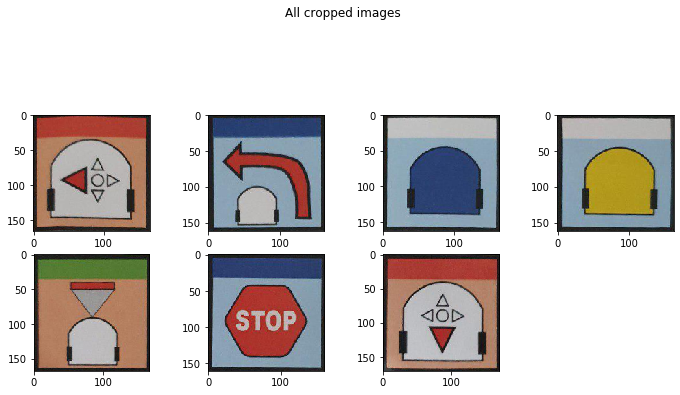

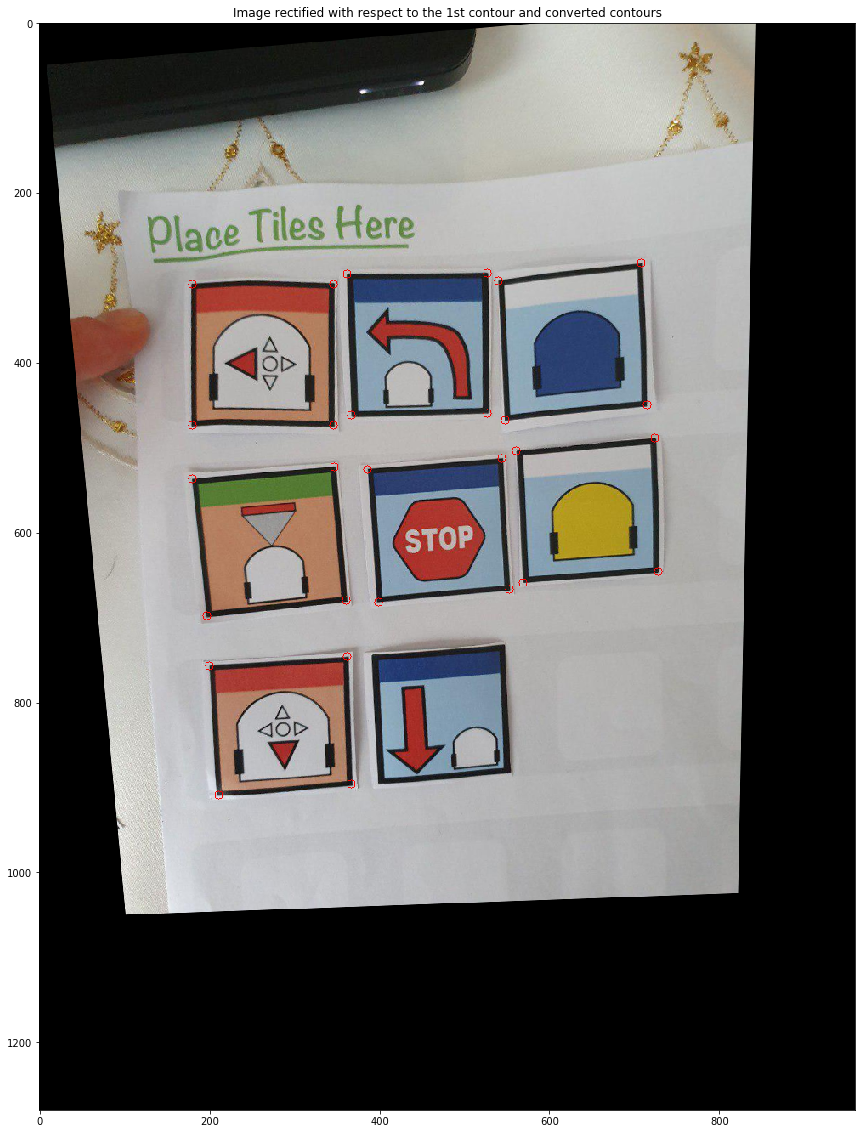

In [19]:
# Constants declaration
HOMOGRAPHY_MARGIN_RATIO = 1.2  # To avoid going inside the image if the contour is close to the border

def rectify_image(contours, img_src, resized_tile_size):
    """Rectify the image vis-a-vis the contours so in the output image, contours are squares aligned horizontally and
    vertically"""
    
    images_rectify = []
    image_rectify = []
    contours_rectify = []

    for index_contour, contour in enumerate(contours):
        upper_leftmost_point = np.array([img_src.shape[1], img_src.shape[0]])
        upper_leftmost_point_index = 0
        for index_point, point in enumerate(contour):
            if point[0] + point[1] < upper_leftmost_point[0] + upper_leftmost_point[1]:
                upper_leftmost_point = point
                upper_leftmost_point_index = index_point

        # Compute the maximum distance between 2 points in contours_copy[0]
        dst_min = img_src.shape[0]
        point_iter = list([x, y] for x in range(4) for y in range(x, 4) if (x != y))
        for iter_point_a, iter_point_b in point_iter:
            distance = sqrt((contour[iter_point_a][0] - contour[iter_point_b][0]) ** 2
                            + (contour[iter_point_a][1] - contour[iter_point_b][1]) ** 2)
            if distance < dst_min:
                dst_min = distance
        dst_min /= HOMOGRAPHY_MARGIN_RATIO

        if dst_min < resized_tile_size:
            continue

        min_x = min(contour, key=lambda x: x[0])[0]
        max_x = max(contour, key=lambda x: x[0])[0]
        min_y = min(contour, key=lambda x: x[1])[1]
        max_y = max(contour, key=lambda x: x[1])[1]
        temp_image = img_src[min_y:max_y, min_x:max_x]

        # Compute the geometrical transformation
        img_src_dst_points = square_from_point(upper_leftmost_point, dst_min, upper_leftmost_point_index)
        upper_leftmost_point = [upper_leftmost_point[0]-min_x, upper_leftmost_point[1]-min_y]
        dst_points = square_from_point(upper_leftmost_point, dst_min, upper_leftmost_point_index)
        crop_contour = np.array([[contour[0][0]-min_x, contour[0][1]-min_y],
                                 [contour[1][0]-min_x, contour[1][1]-min_y],
                                 [contour[2][0]-min_x, contour[2][1]-min_y],
                                 [contour[3][0]-min_x, contour[3][1]-min_y]])

        h, status = cv2.findHomography(crop_contour, dst_points)
        temp_image = cv2.warpPerspective(temp_image, h, (temp_image.shape[1], temp_image.shape[0]))

        if index_contour == 0:
            h_first_contour, _ = cv2.findHomography(np.array(contour), img_src_dst_points)
            image_rectify = cv2.warpPerspective(img_src, h_first_contour, (img_src.shape[1], img_src.shape[0]))

        try:
            contours_rectify.append(convert_contour(contour, h_first_contour))
        except:
            continue

        converted_contour = convert_contour(crop_contour, h)
#         print("crop contour:", crop_contour, "converted_contour:", converted_contour, sep="\n")
        temp_image = temp_image[converted_contour[0][1]:converted_contour[2][1], converted_contour[0][0]:converted_contour[2][0]]
        images_rectify.append(temp_image)

    rectified_object = Rectify(images_rectify, image_rectify, contours_rectify)

    return rectified_object


def get_abs_slope(point_a, point_b):
    """Get the abolute value of the slope between 2 points"""
    if point_a[0] - point_b[0]:
        slope = abs((point_a[1] - point_b[1]) / (point_a[0] - point_b[0]))
    else:
        slope = INFINITY
    if slope > INFINITY:
        slope = INFINITY
    return slope


def square_from_point(point, distance, index=0):
    """Make a square of area distance^2 from the up_left point"""
    output_point = np.array([point,
                             [point[0], point[1] + distance],
                             [point[0] + distance, point[1] + distance],
                             [point[0] + distance, point[1]]])
    output_point = np.roll(output_point, 2*index)
    return output_point


def convert_contour(contour, trans_mat):
    """Convert a contour of point using a 3x3 transformation matrix and sort them clockwise starting from top right"""
    temp_contour = []
    output_contour = []
    for i in range(len(contour)):
        x = int((trans_mat[0][0] * contour[i][0] + trans_mat[0][1] * contour[i][1] + trans_mat[0][2]) /
                (trans_mat[2][0] * contour[i][0] + trans_mat[2][1] * contour[i][1] + trans_mat[2][2]))
        y = int((trans_mat[1][0] * contour[i][0] + trans_mat[1][1] * contour[i][1] + trans_mat[1][2]) /
                (trans_mat[2][0] * contour[i][0] + trans_mat[2][1] * contour[i][1] + trans_mat[2][2]))
        if x < 0: x = 0
        if y < 0: y = 0
        temp_contour.append([x, y])
    output_contour.append(min(temp_contour, key=lambda point: point[0] + point[1]))
    output_contour.append(min(temp_contour, key=lambda point: -point[0] + point[1]))
    output_contour.append(min(temp_contour, key=lambda point: -point[0] - point[1]))
    output_contour.append(min(temp_contour, key=lambda point: point[0] - point[1]))
    return output_contour

rectified_object = rectify_image(contours_frames, image_test, RESIZED_TILE_SIZE)

fig = plt.figure(figsize = (12, 15))
fig.suptitle("All cropped images")
ax = []
for i, image in enumerate(rectified_object.images):
    ax.append(fig.add_subplot(6, 4, i+1))
    RGB_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax[i].imshow(RGB_image)
    
fig2 = plt.figure(figsize = (20, 20))
ax2 = fig2.add_subplot(111)
ax2.set_title("Image rectified with respect to the 1st contour and converted contours")
image_temp = rectified_object.image.copy()
for contour in rectified_object.contours:
    for point in contour:
        cv2.circle(image_temp, (point[0], point[1]), 5, (0, 0, 255))
RGB_image = cv2.cvtColor(image_temp, cv2.COLOR_BGR2RGB)
ax2.imshow(RGB_image)

plt.show()

## Compare tiles
The next step is to compare our cropped contour with our tile librairy. This is done in compare_tile.py.

The main steps are, foreach cropped image in object_rectified.images:
    1. Resizing the image to the size of our resized library. Working with smaller image improves results
    2. Using the matchTemplate function to compare each cropped image with each tile of the library
    3. Keep and assign the tile with the best score to the cropped image
    
It was first planned to compare the images with all the orientation possible but it has been given up because it didn't make sense for the user. The template is still here commented if needed.

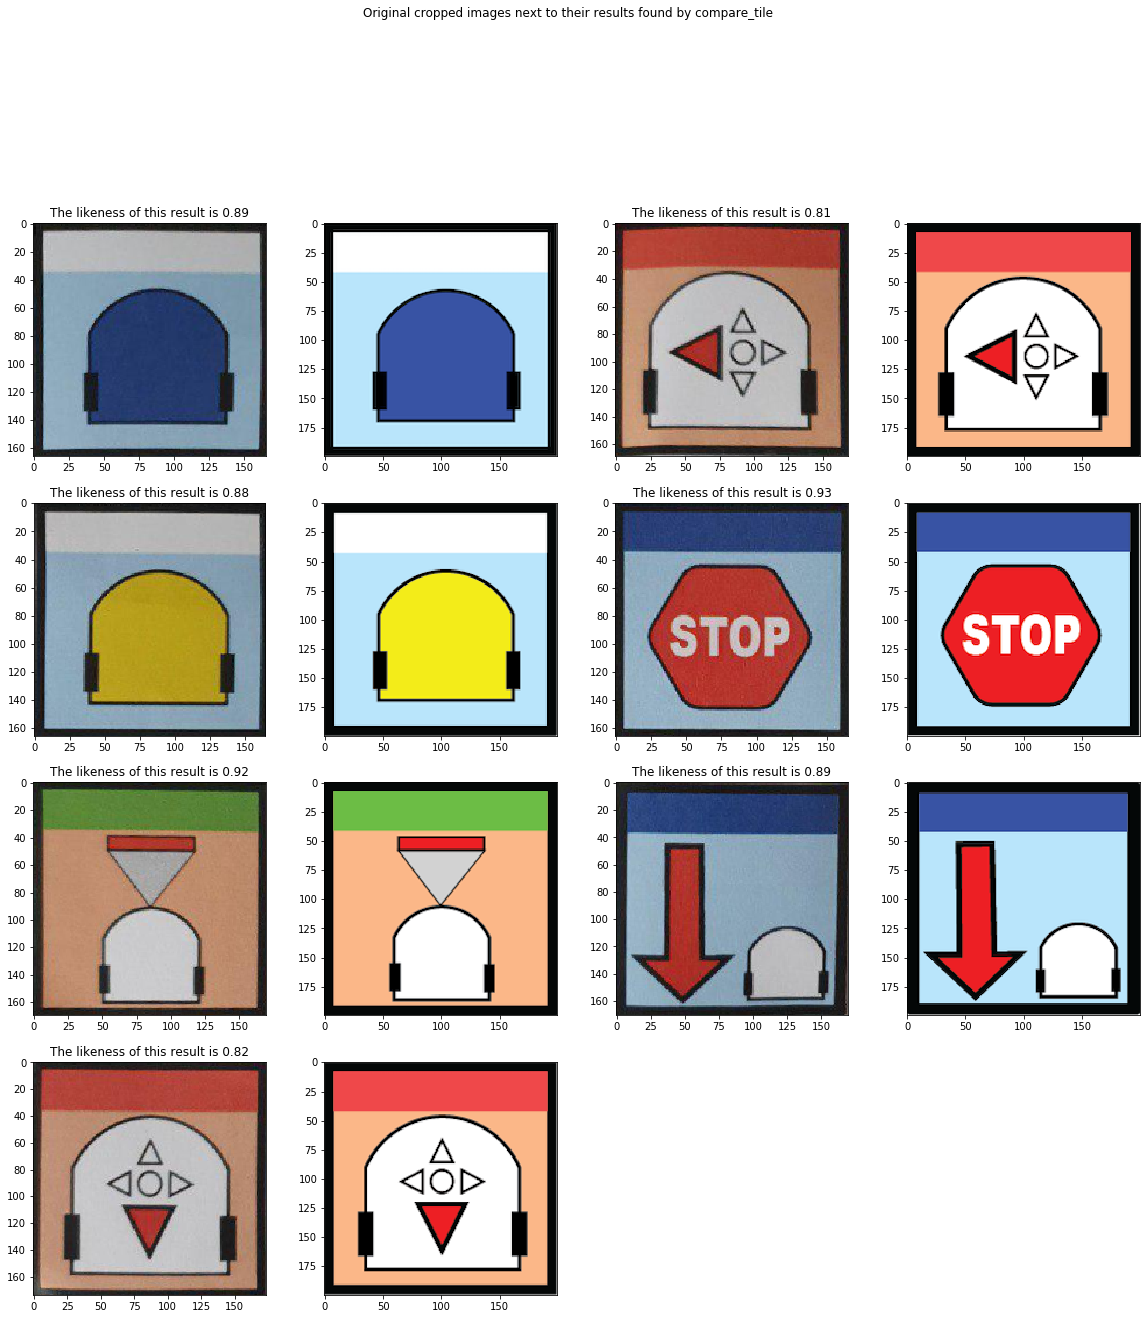

In [42]:
# Constants definition. Here, R, G and B are the index that OpenCV uses for Red, Green and Blue.
RED_BLUE_RATIO = 1.2  # Used to know if the background is clearly blue, red or in between.
LIKENESS_THRESHOLD = 0.3
B = 0
G = 1
R = 2

best_tile_likeness = []  # Only implemeted in the jupyter notebook to show the likeness of each result

def compare_tiles(object_rectified, tile_library, tile_type, tile_size):
    """compare tiles in the image with the library, now we compare direct in color image and not only the edges, we have
    better results"""

    orientation = [0]  # , 90, 180, 270]
    best_tile = []
    best_orientation = []

    for index_image, image in enumerate(object_rectified.images):

        # crop the rectified image to only have the ROI
        size_crop = (tile_size, tile_size)
        try:
            resized_image = cv2.resize(image, size_crop)
        except:
            object_rectified.images.remove(image)
            object_rectified.contours.remove(object_rectified.contours[index_image])
            continue
            
        # The code used to compare the background color whith the tile that didn't have the top band color. They
        # was the background color at the top of the image. This template could be reused for either the background 
        # color or the color of the new top band
#         top_right_band = resized_image[5:10, 25:40, :]
#         top_right_blue = np.sum(top_right_band[:, :, B])
#         top_right_red = np.sum(top_right_band[:, :, R])
#         # print("red: " + str(top_right_red) + " . blue: " + str(top_right_blue))

#         if top_right_red and top_right_blue:
#             if top_right_blue / top_right_red > RED_BLUE_RATIO:
#                 contour_type = save_load.ACTION
#             elif top_right_red / top_right_blue > RED_BLUE_RATIO:
#                 contour_type = save_load.EVENT
#             else:
#                 contour_type = 0
#         elif top_right_red and not top_right_blue:
#             contour_type = save_load.EVENT
#         elif not top_right_red and top_right_blue:
#             contour_type = save_load.ACTION
#         else:
#             contour_type = 0

        # compare the crop image with the edge tile library in the 4 orientations
        best_lib = ""
        best_angle = 0

        # parameter to find the best result
        best_likeness = 0

        for key in tile_library:
            # The following of the previous code for comparing background color. We just skip the tile that are not in
            # the good library
#             if contour_type:
#                 if key not in tile_type[contour_type]:
#                     continue
            (h, w) = tile_library[key].shape[:2]
            # center = (w / 2, h / 2)
            # scale = 1
            for angle in orientation:
                # m_rotation = cv2.getRotationMatrix2D(center, angle, scale)  # takes no time
                # edges_library_rot = cv2.warpAffine(tile_library[key], m_rotation, (h, w))  # 0.5-1 ms
                match = cv2.matchTemplate(tile_library[key], resized_image, cv2.TM_CCOEFF_NORMED)  # ~4-7ms
                _, max_val, _, _ = cv2.minMaxLoc(match)

                if max_val > best_likeness:
                    best_likeness = max_val
                    best_lib = key
                    best_angle = angle

        if best_likeness > LIKENESS_THRESHOLD:
            best_tile.append(best_lib)
            best_tile_likeness.append(best_likeness)
            best_orientation.append(best_angle)
        else:
            best_tile.append('')
            best_orientation.append(best_angle)

    object_rectified.tiles = best_tile
    object_rectified.orientations = best_orientation

    return object_rectified

rectified_object = compare_tiles(rectified_object, session.tile_library_resized, session.tile_type, RESIZED_TILE_SIZE)

fig = plt.figure(figsize = (20, 30))
fig.suptitle("Original cropped images next to their results found by compare_tile")
ax = []
for i in range(len(rectified_object.tiles)):
    ax.append(fig.add_subplot(6, 4, 2*i+1))
    ax.append(fig.add_subplot(6, 4, 2*i+2))
    RGB_image = cv2.cvtColor(rectified_object.images[i], cv2.COLOR_BGR2RGB)
    ax[2*i].imshow(RGB_image)
    ax[2*i].set_title('The likeness of this result is {0}'.format(round(best_tile_likeness[i], 2)))
    RGB_image = cv2.cvtColor(session.tile_library[rectified_object.tiles[i]], cv2.COLOR_BGR2RGB)
    ax[2*i+1].imshow(RGB_image)
    

plt.show()

## Grid and sort_to_grid
We now have all the elements to create a grid : The positions of th contours and their corresponding tile.

The main steps are:
    1. Creating new lists with contour going top-to-bottom and left-to-right (before it wasn't done accurately, 2 tiles on
    the same line could switch position if one was a little upper).
    2. Compute the horizontal and vertical distance between each tile in the grid
    3. Compute the position of each contour according to the previous result. You can see the result of each tile position
    below.
    
It was first planned to also find the orientation of the grid (in case we would rotate the camera by 90/180/270 degrees or if we would like to use the exercise book in another way). We don't use it now but the the template is still here commented (find_grid_orientations).

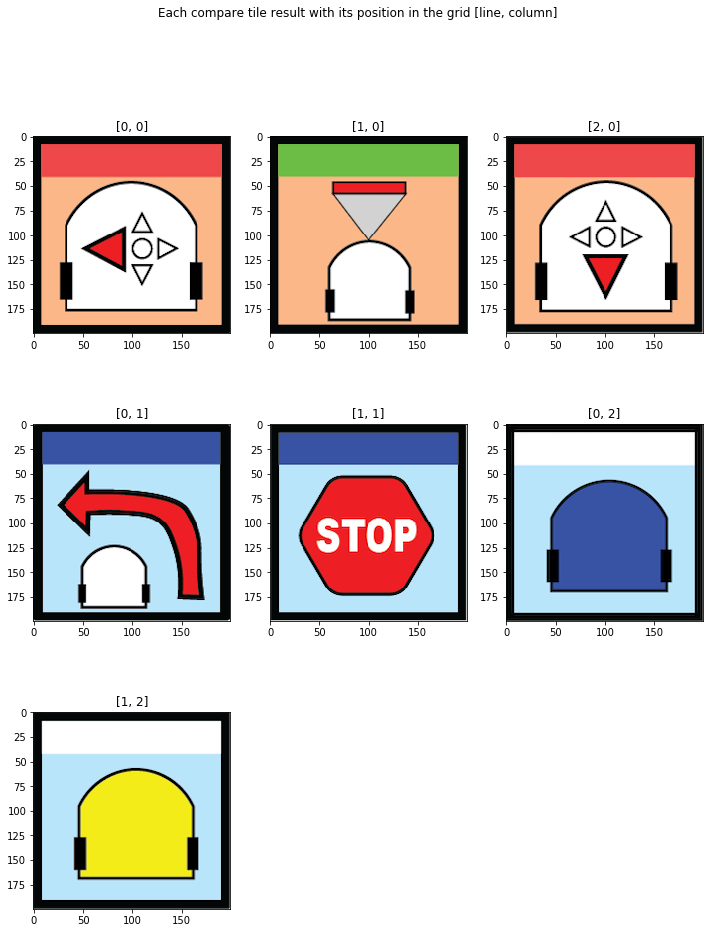

In [21]:
# tolerance used to check whether position in x between 2 points are the same
TOLERANCE = 10
# ratio of the empty space between 2 tiles to the size of the tile
# With the "placing tile" used in the exercices book it is 0.2 and 0.3, respectively
HORIZONTAL_SPACE_TO_SIZE_RATIO = 0.2
VERTCAL_SPACE_TO_SIZE_RATIO = 0.3


def sort_to_grids(object_rectified, tile_library):
    """'Try to sort all the frames in one or several grids so that they an order
    and we can build the VPL program from it."""
    grid = []
    ordered_positions = []
    contour_of_positions = []
    contour_list = object_rectified.contours.copy()
    for trials in range(len(contour_list)):
        current_min_tile, position = min_tile(contour_list, object_rectified.contours)
        ordered_positions.append(position)
        contour_of_positions.append(object_rectified.contours[position])

        contour_list.remove(current_min_tile)

    try:
        diff_x = abs(contour_of_positions[0][2][0] - contour_of_positions[0][0][0]) * (1 + HORIZONTAL_SPACE_TO_SIZE_RATIO)
        diff_y = abs(contour_of_positions[0][2][1] - contour_of_positions[0][0][1]) * (1 + VERTCAL_SPACE_TO_SIZE_RATIO)
    except IndexError:
        return grid, ordered_positions

    if not (diff_x and diff_y):
        return grid, ordered_positions

    for index, position in enumerate(ordered_positions):
        if position == ordered_positions[0]:
            grid.append([0, 0])
        else:
            grid.append(find_position(contour_of_positions[index], contour_of_positions[0][0], diff_x, diff_y))
    # orientation = find_grid_orientation(grid, object_rectified, ordered_positions)

    min_x = 0
    min_y = 0
    for coordinate in grid:
        if coordinate[0] < min_y:
            min_y = coordinate[0]
        if coordinate[1] < min_x:
            min_x = coordinate[1]

    if min_x:
        for coordinate in grid:
            coordinate[1] -= min_x
    if min_y:
        for coordinate in grid:
            coordinate[0] -= min_y

    # print(ordered_positions)
    # print(grid)
    return grid, ordered_positions


def min_tile(contours_list, list_copy):
    """Look for the upper leftmost tile in the image"""
    position = 0

    xy_coord = contours_list[0][0]

    if len(contours_list) >= 1:
        # possible_xy_coord is the Tile with least x-coordinate value
        possible_xy_coord = min(point for point in (min(contour for contour in contours_list)))
        for index, list in enumerate(contours_list):
            for i in range(len(list)):
                # To check least x-coordinate in the range of +/- TOLERANCE with the least y-coordinate as well
                if (list[i][0] < possible_xy_coord[0] + TOLERANCE) and (list[i][0] > possible_xy_coord[0] - TOLERANCE):
                    if list[i][1] < possible_xy_coord[1]:
                        xy_coord = [list[i][0], list[i][1]]
                        possible_xy_coord = xy_coord
                    # If contours_list is left with only one list in it
                    else:
                        xy_coord = possible_xy_coord

        # To find position of min tile in Actual Contour List
        for index, list in enumerate(list_copy):
            if xy_coord in list:
                position = index
        return list_copy[position], position


def find_position(position_contour, origin_contour_upper_leftmost_point, diff_x, diff_y):
    # Look for the upper left point index
    upper_leftmost_point = [position_contour[0][0], position_contour[0][1]]
    for index, point in enumerate(position_contour):
        if point[0] + point[1] < upper_leftmost_point[0] + upper_leftmost_point[1]:
            upper_leftmost_point = point

    pos_x = round((upper_leftmost_point[0] - origin_contour_upper_leftmost_point[0]) / diff_x)
    pos_y = round((upper_leftmost_point[1] - origin_contour_upper_leftmost_point[1]) / diff_y)

    return [pos_y, pos_x]


def find_grid_orientation(grid, rectified_object, position_list):
    event_tiles = ["add tile", "default_lib", "Button_Bottom", "Button_Center", "Button_Left", "Button_Right",
                   "Button_Top", "Clap", "Event_Color_Blue", "Event_Color_Green", "Event_Color_Red",
                   "Event_Color_Yellow", "Ground_Black_White", "Ground_Black", "Ground_Edge", "Ground_White_Black",
                   "Ground_White", "Obstacle_Front", "Obstacle_Right", "Obstacle_Left"]
    orientation = "Default"
    max_events = 0
    events_left = 0
    events_right = 0
    events_top = 0
    events_bottom = 0
    max_row = 0
    max_column = 0

    # Check if all tiles in 1st column are events, i.e. events_left
    for index, list in enumerate(grid):
        if list[1] == 0:
            column_tile = rectified_object.tiles[position_list.index(index)]
            # print("Column Tile: " + column_tile)
            if column_tile in event_tiles:
                events_left += 1
                if events_left > max_events:
                    max_events = events_left
                    orientation = "Left"
        # Meanwhile, to find number of rows in the grid
        if list[0] > max_row:
            max_row = list[0]

    # Check if all tiles in 1st row are events, i.e. events_top
    for index, list in enumerate(grid):
        if list[0] == 0:
            row_tile = rectified_object.tiles[position_list.index(index)]
            # print("Row Tile: " + row_tile)
            if row_tile in event_tiles:
                events_top += 1
                if events_top > max_events:
                    max_events = events_top
                    orientation = "Top"
        # Meanwhile, to find number of columns in the grid
        if list[1] > max_column:
            max_column = list[1]

    # Check if all tiles in last row, i.e events_bottom
    for index, list in enumerate(grid):
        if list[0] == max_row:
            row_tile = rectified_object.tiles[position_list.index(index)]
            if row_tile in event_tiles:
                events_bottom += 1
                if events_bottom > max_events:
                    max_events = events_bottom
                    orientation = "Bottom"

    # Check if all tiles in last column, i.e. events right
    for index, list in enumerate(grid):
        if list[1] == max_column:
            column_tile = rectified_object.tiles[position_list.index(index)]
            if column_tile in event_tiles:
                events_right += 1
                if events_right > max_events:
                    max_events = events_right
                    orientation = "Right"

    if max_events == 0:
        orientation = "No events"
    # print(orientation)
    return orientation


rectified_object.grid_list, rectified_object.grid_order = sort_to_grids(rectified_object, 
                                                                              tile_library_resized)

fig = plt.figure(figsize = (12, 15))
fig.suptitle("Each compare tile result with its position in the grid [line, column]")
ax = []
for i in range(len(rectified_object.tiles)):
    ax.append(fig.add_subplot(3, 3, i+1))
    RGB_image = cv2.cvtColor(session.tile_library[rectified_object.tiles[rectified_object.grid_order[i]]], 
                             cv2.COLOR_BGR2RGB)
    ax[i].imshow(RGB_image)
    ax[i].title.set_text(str(rectified_object.grid_list[i]))
    

plt.show()

## Average
Now that we have our result, we can make an average out of the last N results. We do this with the function called update_program.

The main steps are:
    1. We check if rectified_object.contours is empty. 
        If it is, we call update_void_program which just add an empty result in both session.average_tile and
        session.average_grid and skip steps 2-4. Otherwise we continue to step 2.
    2. We compute min_line and min_column in case there are some negative index (this should only happens with columns)
    3. We substract min_line and min_column to the grid_list positions
    4. We update session.average_tile and session.average_grid with the previous result
    5. We call find_best_program which update session.best_grid and session.best_tile according to session.average_tile 
    and session.average_grid. One can notice in find_best_program that we lower the importance of empty tiles in order to
    increase the probability to get a non-void resulty.
    
To show the results of average, we are going to repeat this step and all the previous one with 20 different pictures of the same tiles.

In [22]:
# Must be a multiple of 5
AVERAGE_LENGTH = 20


def update_program(rectified_object, session):
    if len(rectified_object.contours):
        try:
            min_line = min(point[0] for point in rectified_object.grid_list)
            min_column = min(point[1] for point in rectified_object.grid_list)
        except ValueError:  # If the recified_object is empty
            return
        temp_grid_list = []
        temp_tile_list = []
        for average_index in range(len(rectified_object.grid_list)):
            try:
                tile = rectified_object.tiles[rectified_object.grid_order[average_index]]
            except:
                tile = ''
            grid = rectified_object.grid_list[average_index]
            line = grid[0] - min_line
            col = grid[1] - min_column
            temp_tile_list.append(tile)
            temp_grid_list.append([line, col])

        if len(session.average_tile) < AVERAGE_LENGTH:
            session.average_tile.append(temp_tile_list)
            session.average_grid.append(temp_grid_list)
        else:
            for average_index in range(AVERAGE_LENGTH - 1, 0, -1):
                session.average_tile[average_index] = session.average_tile[average_index - 1]
                session.average_grid[average_index] = session.average_grid[average_index - 1]
            session.average_tile[0] = temp_tile_list
            session.average_grid[0] = temp_grid_list
    else:
        update_void_program(session)

    find_best_program(session)

    return


def update_void_program(session):
    if len(session.average_tile) < AVERAGE_LENGTH:
        session.average_tile = []
        session.average_grid = []

    else:
        for average_index in range(AVERAGE_LENGTH - 1, 0, -1):
            session.average_tile[average_index] = session.average_tile[average_index - 1]
            session.average_grid[average_index] = session.average_grid[average_index - 1]
        session.average_tile[0] = []
        session.average_grid[0] = []

    find_best_program(session)

    return


def find_best_program(session):
    max_line = 0
    max_column = 0
    for average_index in range(len(session.average_grid)):
        if session.average_grid[average_index]:
            min_line = min(point[0] for point in session.average_grid[average_index])
            min_column = min(point[1] for point in session.average_grid[average_index])
            nb_line = max(point[0] for point in session.average_grid[average_index]) - min_line + 1
            nb_column = max(point[1] for point in session.average_grid[average_index]) - min_column + 1
            if nb_line > max_line:
                max_line = nb_line
            if nb_column > max_column:
                max_column = nb_column

    session.best_grid = []
    session.best_tile = []

    for no_line in range(max_line):
        for no_column in range(max_column):
            counter = {}
            session.best_grid.append([no_line, no_column])
            for average_index in range(len(session.average_tile)):
                grid_is_found = 0
                for tile_index in range(len(session.average_tile[average_index])):
                    tile = session.average_tile[average_index][tile_index]
                    grid = session.average_grid[average_index][tile_index]
                    if grid != [no_line, no_column]:
                        continue
                    else:
                        grid_is_found = 1
                        if tile in counter:
                            counter[tile] = counter[tile] + 1
                        else:
                            counter[tile] = 1
                if not grid_is_found:
                    if '' in counter:
                        counter[''] = counter[''] + 1
                    else:
                        counter[''] = 1
            if '' in counter:
                counter[''] = counter[''] - AVERAGE_LENGTH / 5
            session.best_tile.append(max(counter, key=lambda k: counter[k]))


def update_program_file(rectified_object, session):
    if len(rectified_object.contours):
        min_line = min(point[0] for point in rectified_object.grid_list)
        min_column = min(point[1] for point in rectified_object.grid_list)
        session.average_tile = []
        session.average_grid = []
        temp_average_tile = []
        temp_average_grid = []
        for object_index in range(len(rectified_object.grid_list)):
            try:
                tile = rectified_object.tiles[rectified_object.grid_order[object_index]]
            except:
                tile = ''
            grid = rectified_object.grid_list[object_index]
            line = grid[0] - min_line
            col = grid[1] - min_column
            temp_average_tile.append(tile)
            temp_average_grid.append([line, col])
        for average_index in range(AVERAGE_LENGTH):
            session.average_grid.append(temp_average_grid)
            session.average_tile.append(temp_average_tile)
        find_best_program(session)
    else:
        session.best_tile = []
        session.best_grid = []
        
for i in range(20):
    image_test = cv2.imread("data/test/test (" + str(i+1) + ").jpg")
    contours_frames = find_contour_frames(image_test, False)
    rectified_object = rectify_image(contours_frames, image_test, RESIZED_TILE_SIZE)
    rectified_object = compare_tiles(rectified_object, session.tile_library_resized, session.tile_type, RESIZED_TILE_SIZE)
    rectified_object.grid_list, rectified_object.grid_order = sort_to_grids(rectified_object, session.tile_library_resized)

    update_program(rectified_object, session)
    
print('Finished.')

Finished.


## Program
We can now directly use our last Image Processing functions to show the results : Program.show_best_program

This function takes session in input and gives 2 outputs:
    - program_tile, a table which contains the program (the tiles name at the correct positions)
    - program_img, an image of the program
   
We also implemented a function to show the rectified image but it was mainly for debugging and it's not used anymore.

[['Button_Left' None 'Action_Color_Blue']
 ['Obstacle_Front' 'Motors_Stop' 'Action_Color_Yellow']
 ['Button_Bottom' None None]]


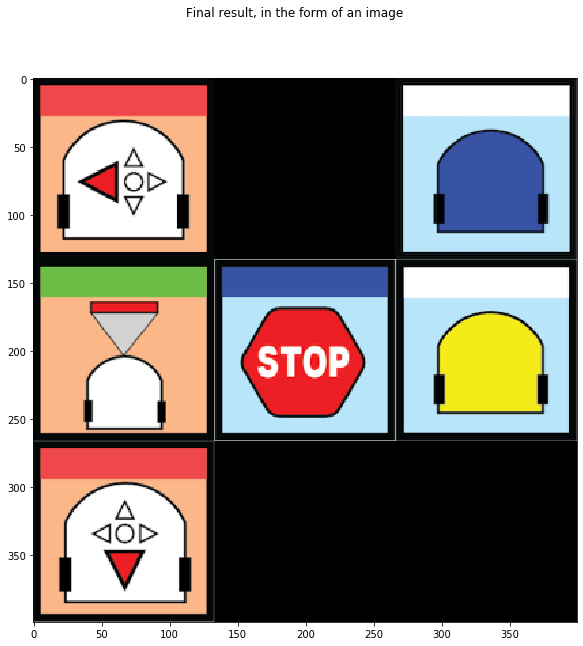

In [23]:
IMAGE_SIZE = 400  # To avoid having too big image

def show_best_program(session, tile_size):
    program_tile = np.empty((1, 1), dtype=object)
    if session.best_grid != [] and session.best_tile != []:
        nb_line = max(point[0] for point in session.best_grid) + 1
        nb_column = max(point[1] for point in session.best_grid) + 1
        program_img = np.zeros((tile_size * nb_line, tile_size * nb_column, 3), dtype=np.uint8)
        program_tile = np.resize(program_tile, (nb_line, nb_column))
        for tile, grid in zip(session.best_tile, session.best_grid):
            if tile == '':
                continue
            line = grid[0]
            col = grid[1]
            program_img[tile_size * line:tile_size * (line + 1), tile_size * col:tile_size * (col + 1), :] = \
                session.tile_library[tile]
            program_tile[line, col] = tile

        ratio = IMAGE_SIZE / max([nb_line, nb_column]) / tile_size
        program_img_width = int(program_img.shape[1] * ratio)
        program_img_height = int(program_img.shape[0] * ratio)
        program_img = cv2.resize(program_img, (program_img_width, program_img_height))  # Maybe width and height
        # should be reversed
    else:
        program_img = []

    return program_tile, program_img


def show_rectified_image(rectified_object):
    if len(rectified_object.contours):
        rectified_img = rectified_object.image
        for contour in rectified_object.contours:
            if contour == rectified_object.contours[0]:
                cv2.circle(rectified_img, tuple(contour[0]), 15, (255, 0, 0))
                cv2.circle(rectified_img, tuple(contour[1]), 15, (0, 255, 0))
                cv2.circle(rectified_img, tuple(contour[2]), 15, (0, 0, 255))
                cv2.circle(rectified_img, tuple(contour[3]), 15, (255, 255, 0))
            cv2.circle(rectified_img, tuple(contour[0]), 5, (255, 0, 0), -1)
            cv2.circle(rectified_img, tuple(contour[1]), 5, (0, 255, 0), -1)
            cv2.circle(rectified_img, tuple(contour[2]), 5, (0, 0, 255), -1)
            cv2.circle(rectified_img, tuple(contour[3]), 5, (255, 255, 0), -1)
        ratio = IMAGE_SIZE / max(rectified_img.shape) * 2
        rectified_img_width = int(rectified_img.shape[1] * ratio)
        rectified_img_height = int(rectified_img.shape[0] * ratio)
        rectified_img = cv2.resize(rectified_img, (rectified_img_width, rectified_img_height))  # Maybe width and height
        # should be reversed
        cv2.imshow("rectified image", rectified_img)
    else:
        cv2.destroyWindow("rectified image")
        
        
session.program_tile, session.best_program = show_best_program(session, ORIGINAL_TILE_SIZE)

print(session.program_tile)

fig = plt.figure(figsize = (12, 10))
fig.suptitle("Final result, in the form of an image")
ax = fig.add_subplot(111)
RGB_image = cv2.cvtColor(session.best_program, cv2.COLOR_BGR2RGB)
ax.imshow(RGB_image)
    

plt.show()

# Main
We can now using our interface and the whole program through our main function. I highly advise you not to try it directly in the jupyter notebook. Even if it may work, it can introduce a lot of bugs with the tkinter library.

In [ ]:
if __name__ == '__main__':
    # Can be useful if we want to work simultaneously with several sessions
    # Need to be implemented
    my_sessions = [Session()]
    working_session = 0
    th = None

    # GUI Initialization
    root = tk.Tk()
    myApp = Interface(root, my_sessions[working_session], "PaPL")
    root.protocol("WM_DELETE_WINDOW", myApp.on_delete)

    while True:
        if my_sessions[working_session].state == States.GAME_CHOICE:
            while my_sessions[working_session].state == States.GAME_CHOICE:
                my_sessions[working_session].reset()
                module = myApp.get_choice("Game choice", "Choose your game", ["Thymio", "ScratchJr", "Exit"])
                if module == "Thymio":
                    my_sessions[working_session].module_logo = Image.open(os.getcwd() + "/data/logo/thymio_logo.png")
                    my_sessions[working_session].module = Module.THYMIO
                    tile_library, tile_library_resized, tile_type = load_data(Module.THYMIO)
                    if not th:
                        ports = serial.tools.list_ports.comports()
                        device = None
                        for port in ports:
                            if 'Thymio' in port.description:
                                device = port.device
                        if device:
                            th = Thymio.serial(port=device, refreshing_rate=0.1)
                            dir(th)
                            time.sleep(1)
                            variables = th.variable_description()
                            time.sleep(2)
                        else:
                            myApp.show_info("Info", "No thymio has been found. Please connect a thymio.")
                            continue
                elif module == "ScratchJr":
                    my_sessions[working_session].module_logo = Image.open(os.getcwd() + "/data/logo/scratchjr_logo.png")

                    for root, dirs, files in os.walk("C:\\"):
                        if 'ScratchJr.exe' in files:
                            path_scratch_exe = os.path.join(root, 'ScratchJr.exe')
                            path_scratch_exe = path_scratch_exe.replace("\\", "/")
                            break
                    for root, dirs, files in os.walk("C:\\"):
                        if 'scratchjr.sqllite' in files:
                            path_scratch_sql = os.path.join(root)
                            path_scratch_sql = path_scratch_sql.replace("\\", "/")
                            break
                    for root, dirs, files in os.walk(path_scratch_sql):
                        if not 'scratchjr.sqllite.restore' in files:
                            bsp.create_sql_file(path_scratch_sql)
                    os.system(path_scratch_exe)
                    my_sessions[working_session].module = Module.SCRATCH
                    tile_library, tile_library_resized, tile_type = load_data(Module.SCRATCH)

                    scenery = myApp.get_choice("Scenery choice", "Select a scenery", ["Farm", "Park", "Fall",
                                                                                      "BeachDay"])
                    my_sessions[working_session].scenery = scenery + ".svg"
                    my_sessions[working_session].character = myApp.get_choice("Character choice", "Select a character",
                                                                              ["Tic", "Tac", "Toc", "Dragon", "Fairy",
                                                                               "Wizard"])
                elif module =="Exit":
                    my_sessions[working_session].state = States.EXIT
                    break
                else:
                    continue
                my_sessions[working_session].tile_library = tile_library
                my_sessions[working_session].tile_library_resized = tile_library_resized
                my_sessions[working_session].tile_type = tile_type
                my_sessions[working_session].state = States.IMG_SOURCE_CHOICE

        elif my_sessions[working_session].state == States.IMG_SOURCE_CHOICE:
            while my_sessions[working_session].state == States.IMG_SOURCE_CHOICE:
                source_choice = myApp.get_choice("Source choice",
                                                 "Choose the source between webcam, image files or capture mode",
                                                 ["webcam", "image files", "capture", "exit"])
                if source_choice == "webcam":
                    my_sessions[working_session].state = States.WEBCAM_CHOICE
                elif source_choice == "image files":
                    my_sessions[working_session].state = States.IMG_FILE_MAIN
                elif source_choice == "capture":
                    my_sessions[working_session].state = States.CAPTURE_CHOICE
                elif source_choice == "exit":
                    my_sessions[working_session].state = States.EXIT
                else:
                    my_sessions[working_session].state = States.EXIT

        elif my_sessions[working_session].state == States.WEBCAM_CHOICE:
            while my_sessions[working_session].state == States.WEBCAM_CHOICE:
                # cap_choice = myApp.get_integer("Webcam number", "Please enter the webcam number")
                cap_choice = 0
                try:
                    cap = cv2.VideoCapture(int(cap_choice))
                    if cap.isOpened():
                        my_sessions[working_session].state = States.WEBCAM_MAIN
                except TypeError:
                    my_sessions[working_session].state = States.IMG_SOURCE_CHOICE

        elif my_sessions[working_session].state == States.WEBCAM_MAIN:
            my_sessions[working_session].current_event_tile = None
            if my_sessions[working_session].module == Module.THYMIO:
                btp.init_thymio(th)
            while my_sessions[working_session].state == States.WEBCAM_MAIN:
                ret, image = cap.read()
                if not ret:
                    print("The program was not able to capture image from the webcam")
                    my_sessions[working_session].state == States.WEBCAM_CHOICE
                else:
                    image = cv2.flip(image, 1)
                    image = cv2.resize(image, (1200, 900))
                    interpret_image(image, my_sessions[working_session])
                    try:
                        myApp.update_gui(image, program=my_sessions[working_session].best_program)
                    except tk.TclError:
                        sys.exit(0)

        elif my_sessions[working_session].state == States.LAUNCH_WEBCAM:
            while my_sessions[working_session].state == States.LAUNCH_WEBCAM:
                try:
                    myApp.update_gui(image, program=my_sessions[working_session].best_program)
                except tk.TclError:
                    sys.exit(0)
                if my_sessions[working_session].program_tile.any():
                    save_file(my_sessions[working_session].best_program)
                    my_sessions[working_session].state = States.EXECUTE_WEBCAM
                else:
                    my_sessions[working_session].state = States.WEBCAM_MAIN

        elif my_sessions[working_session].state == States.EXECUTE_WEBCAM:
            flag = False
            while my_sessions[working_session].state == States.EXECUTE_WEBCAM:
                try:
                    myApp.update_gui(image, program=my_sessions[working_session].best_program)
                except tk.TclError:
                    sys.exit(0)
                if my_sessions[working_session].module == Module.THYMIO:
                    flag = execute(flag, my_sessions[working_session], th=th)
                else:
                    flag = execute(flag, my_sessions[working_session], path_to_scratch=path_scratch_sql)

        elif my_sessions[working_session].state == States.IMG_FILE_MAIN:
            my_sessions[working_session].current_event_tile = None
            if my_sessions[working_session].module == Module.THYMIO:
                btp.init_thymio(th)
            flag = False
            while my_sessions[working_session].state == States.IMG_FILE_MAIN:
                if not flag:
                    file_path = myApp.get_text("Path to file", "Enter the file address")
                    if file_path == "q" or file_path == "None":
                        my_sessions[working_session].state = States.IMG_SOURCE_CHOICE
                        break
                    try:
                        image = cv2.imread("data/" + file_path)
                    except TypeError:
                        my_sessions[working_session].state = States.IMG_SOURCE_CHOICE
                    if image is None:
                        print("Invalid or missing file.")
                    else:
                        flag = True
                        image = cv2.resize(image, (1200, 900))
                        interpret_image(image, my_sessions[working_session])
                try:
                    myApp.update_gui(image, program=my_sessions[working_session].best_program)
                except tk.TclError:
                    sys.exit(0)

        elif my_sessions[working_session].state == States.LAUNCH_FILE:
            while my_sessions[working_session].state == States.LAUNCH_FILE:
                try:
                    myApp.update_gui(image, program=my_sessions[working_session].best_program)
                except tk.TclError:
                    sys.exit(0)
                if my_sessions[working_session].program_tile.any():
                    save_file(my_sessions[working_session].best_program)
                    my_sessions[working_session].state = States.EXECUTE_FILE
                else:
                    my_sessions[working_session].state = States.IMG_FILE_MAIN

        elif my_sessions[working_session].state == States.EXECUTE_FILE:
            flag = False
            while my_sessions[working_session].state == States.EXECUTE_FILE:
                try:
                    myApp.update_gui(image, program=my_sessions[working_session].best_program)
                except tk.TclError:
                    sys.exit(0)
                if my_sessions[working_session].module == Module.THYMIO:
                    flag = session.execute(flag, my_sessions[working_session], th=th)
                else:
                    flag = session.execute(flag, my_sessions[working_session], path_to_scratch=path_scratch_sql)

        elif my_sessions[working_session].state == States.CAPTURE_CHOICE:
            while my_sessions[working_session].state == States.CAPTURE_CHOICE:
                cap_choice = myApp.get_integer("Webcam number", "Please enter the webcam number")
                try:
                    cap = cv2.VideoCapture(int(cap_choice))
                    if cap.isOpened():
                        my_sessions[working_session].state = States.CAPTURE_MAIN
                except TypeError:
                    my_sessions[working_session].state = States.IMG_SOURCE_CHOICE

        elif my_sessions[working_session].state == States.CAPTURE_MAIN:
            my_sessions[working_session].current_event_tile = None
            if my_sessions[working_session].module == Module.THYMIO:
                btp.init_thymio(th)
            while my_sessions[working_session].state == States.CAPTURE_MAIN:
                ret, image = cap.read()
                if not ret:
                    print("The program was not able to capture image from the webcam")
                    my_sessions[working_session].state == States.CAPTURE_CHOICE
                else:
                    image = cv2.resize(image, (1200, 900))
                    interpret_image(image, my_sessions[working_session])
                    try:
                        myApp.update_gui(image, program=my_sessions[working_session].best_program)
                    except tk.TclError:
                        sys.exit(0)

        elif my_sessions[working_session].state == States.LAUNCH_CAPTURE:
            while my_sessions[working_session].state == States.LAUNCH_CAPTURE:
                try:
                    myApp.update_gui(image, program=my_sessions[working_session].best_program)
                except tk.TclError:
                    sys.exit(0)
                if my_sessions[working_session].program_tile.any():
                    save_file(my_sessions[working_session].best_program)
                    my_sessions[working_session].state = States.EXECUTE_CAPTURE
                else:
                    my_sessions[working_session].state = States.CAPTURE_MAIN

        elif my_sessions[working_session].state == States.EXECUTE_CAPTURE:
            flag = False
            while my_sessions[working_session].state == States.EXECUTE_CAPTURE:
                try:
                    myApp.update_gui(image, program=my_sessions[working_session].best_program)
                except tk.TclError:
                    sys.exit(0)
                if my_sessions[working_session].module == Module.THYMIO:
                    flag = execute(flag, my_sessions[working_session], th=th)
                else:
                    flag = execute(flag, my_sessions[working_session], path_to_scratch=path_scratch_sql)

        elif my_sessions[working_session].state == States.EXIT:
            print("fermeture du programme")
            try:
                root.destroy()
            except tk.TclError:
                pass  # root is already destroyed
            sys.exit(0)

        else:
            myApp.show_info("Unknown error", "Session " + str(working_session) + " has stopped working. "
                            "Please restart the program")
            sys.exit(0)